In [1]:
import dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve,auc, RocCurveDisplay

In [2]:
dataset_path = 'dataset.parquet'

In [3]:
ds = dataset.VorAusDataset(dataset_path)

In [4]:
X_train, y_train, X_test, y_test = ds.get_prepared_dataset_tts(test_size = 0.15, random_state=42)

## Model evaluation

In [5]:
class Model:
    def __init__(self, model,name=None, scaled=False):
        self.model = model
        self.name = name
    def fit(self):
        self.model.fit(X_train, y_train)
    def __get_predictions(self):
        return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]

    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series

    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

* $Recall = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$
    * In words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?" It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.


* $Precision = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}$ 
    * In words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?" It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
* $Accuracy = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$
* $F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} \times \text{Recall}}$
    * In words, the F1 score provides a balance between precision and recall. It ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 indicates poor performance

In [6]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
            'Precision',
            'Recall',
            'F1-Score',
            'ROC AUC',
            'Confusion Matrix',
            'PR AUC'])

## Logistic Regression

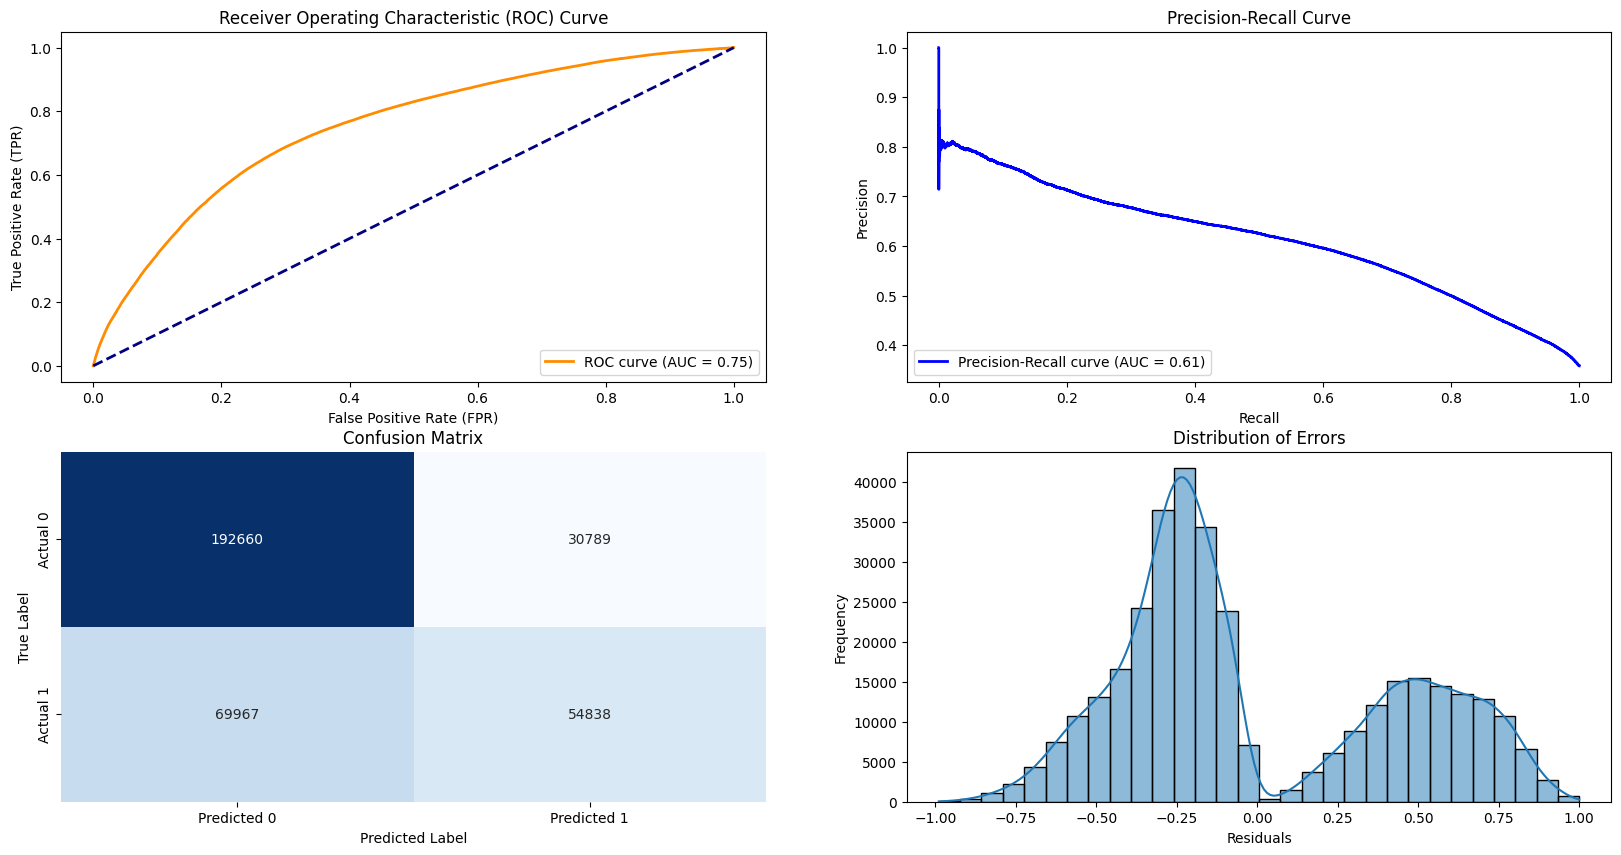

In [8]:
model = Model(LogisticRegression(solver='newton-cholesky'),'Logistic Regression')
model.fit()
model.visualize_metrics()

In [9]:
metrics_lr = model.get_metrics()
models_df = pd.concat([models_df, metrics_lr.to_frame().T])
print(metrics_lr)

Accuracy                                     0.710682
Precision                                    0.640429
Recall                                       0.439389
F1-Score                                     0.521194
ROC AUC                                       0.74864
Confusion Matrix    [[192660, 30789], [69967, 54838]]
PR AUC                                       0.610888
Name                              Logistic Regression
dtype: object


In [10]:
del metrics_lr
del model

# Gaussian Naive Bayes

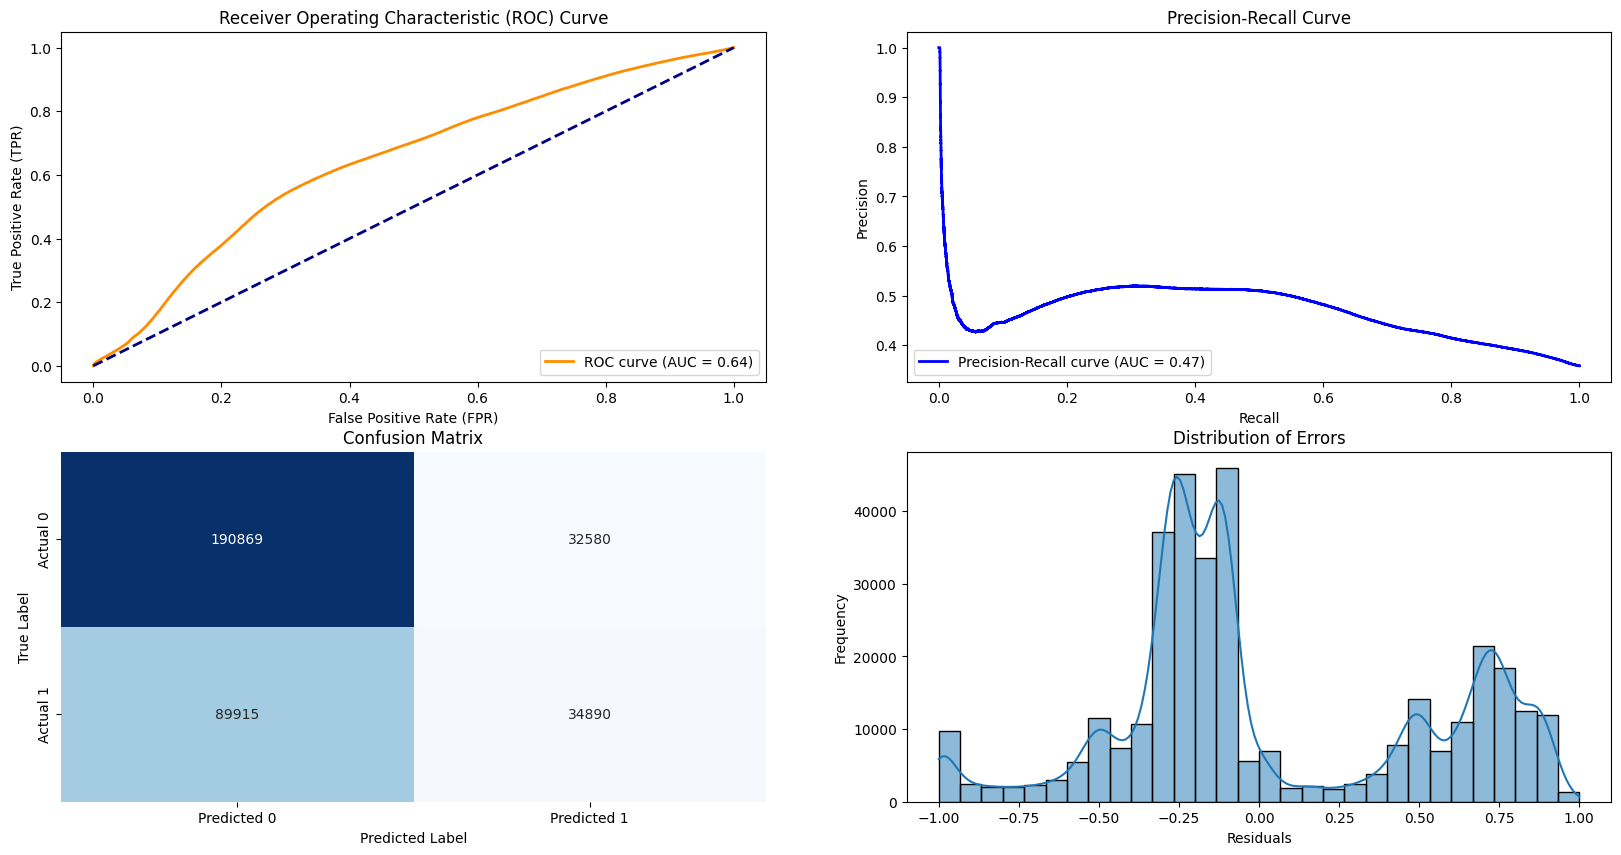

In [11]:
model = Model(GaussianNB(), 'Gaussian Naive Bayes')
model.fit()
model.visualize_metrics()

In [12]:
metrics_LB = model.get_metrics()
models_df = pd.concat([models_df, metrics_LB.to_frame().T])
print(metrics_LB)

Accuracy                                      0.64826
Precision                                    0.517119
Recall                                       0.279556
F1-Score                                     0.362918
ROC AUC                                      0.643212
Confusion Matrix    [[190869, 32580], [89915, 34890]]
PR AUC                                       0.466222
Name                             Gaussian Naive Bayes
dtype: object


In [13]:
del model
del metrics_LB

## Decision Tree

In [14]:
model = Model(DecisionTreeClassifier(), 'Decision Tree Classifier')
model.fit()
model.visualize_metrics()

KeyboardInterrupt: 

In [16]:
metrics_DT = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT.to_frame().T])
print(metrics_DT)

Accuracy                                      0.874184
Precision                                     0.825218
Recall                                          0.8233
F1-Score                                      0.824258
ROC AUC                                       0.862952
Confusion Matrix    [[201686, 21763], [22053, 102752]]
PR AUC                                        0.742727
Name                          Decision Tree Classifier
dtype: object


In [ ]:
del model
del metrics_DT

## Grid search for best Decision Tree

In [ ]:
param_grid = {
    'max_depth': [None, 5, 10, 15,20, 25],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the model to the data (search for the best hyperparameters)
grid_search.fit(X_train, y_train)

## Random Forest

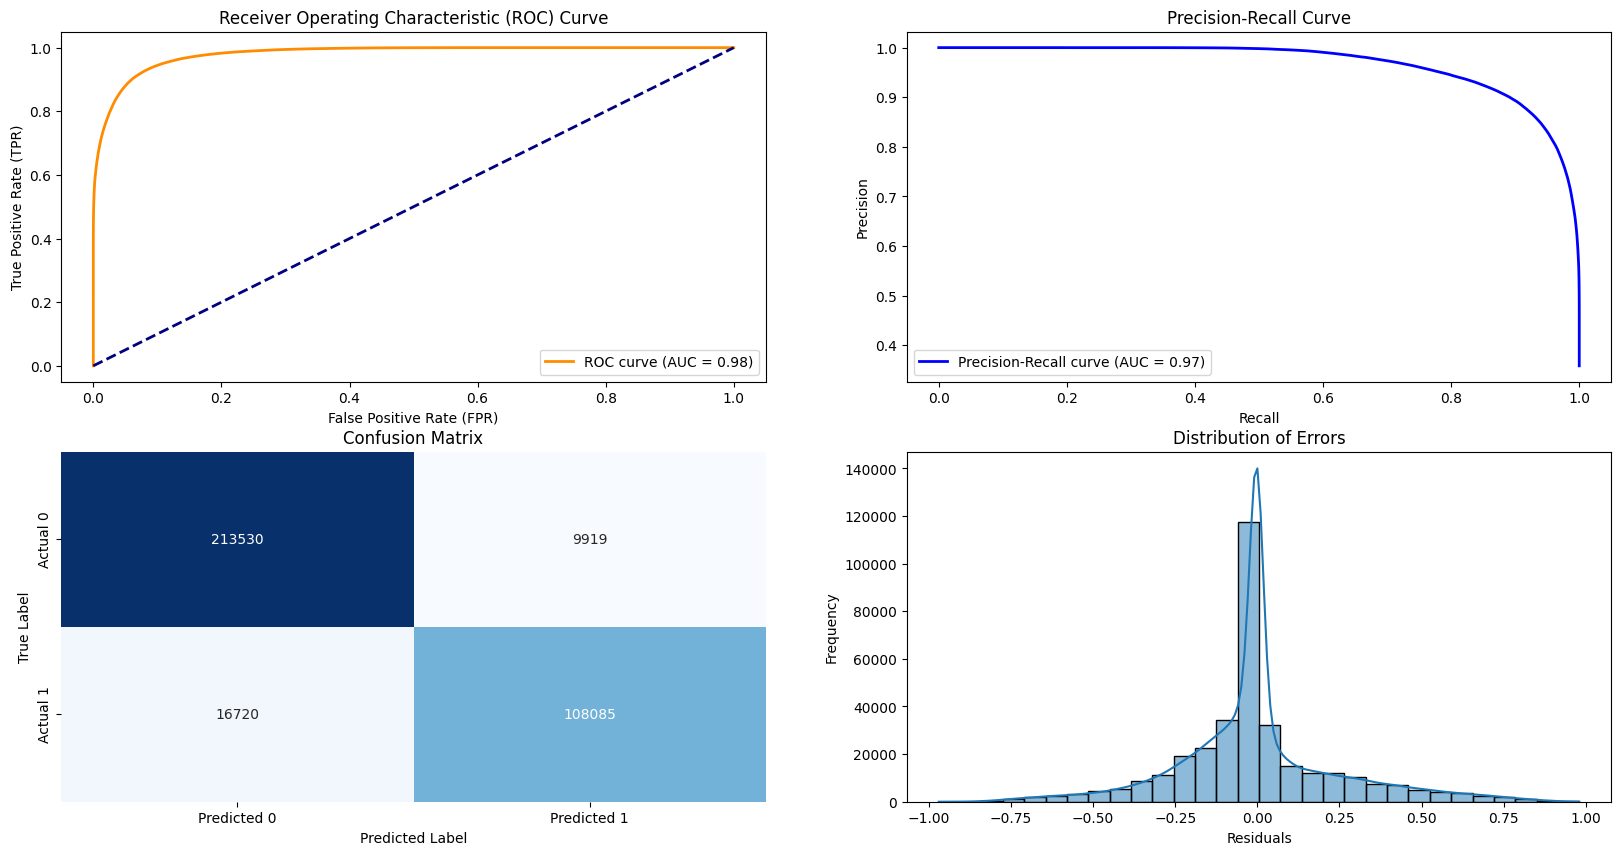

In [12]:
model = Model(RandomForestClassifier())
model.fit()
model.visualize_metrics()  

In [13]:
metrics_RandomForest = model.get_metrics()
models_df = pd.concat([models_df, metrics_RandomForest.to_frame().T])
print(metrics_RandomForest)

Accuracy                                     0.923507
Precision                                    0.915944
Recall                                       0.866031
F1-Score                                     0.890288
ROC AUC                                      0.979646
Confusion Matrix    [[213530, 9919], [16720, 108085]]
PR AUC                                       0.965638
Name                           RandomForestClassifier
dtype: object


In [10]:
del model

# Gradient Boosting

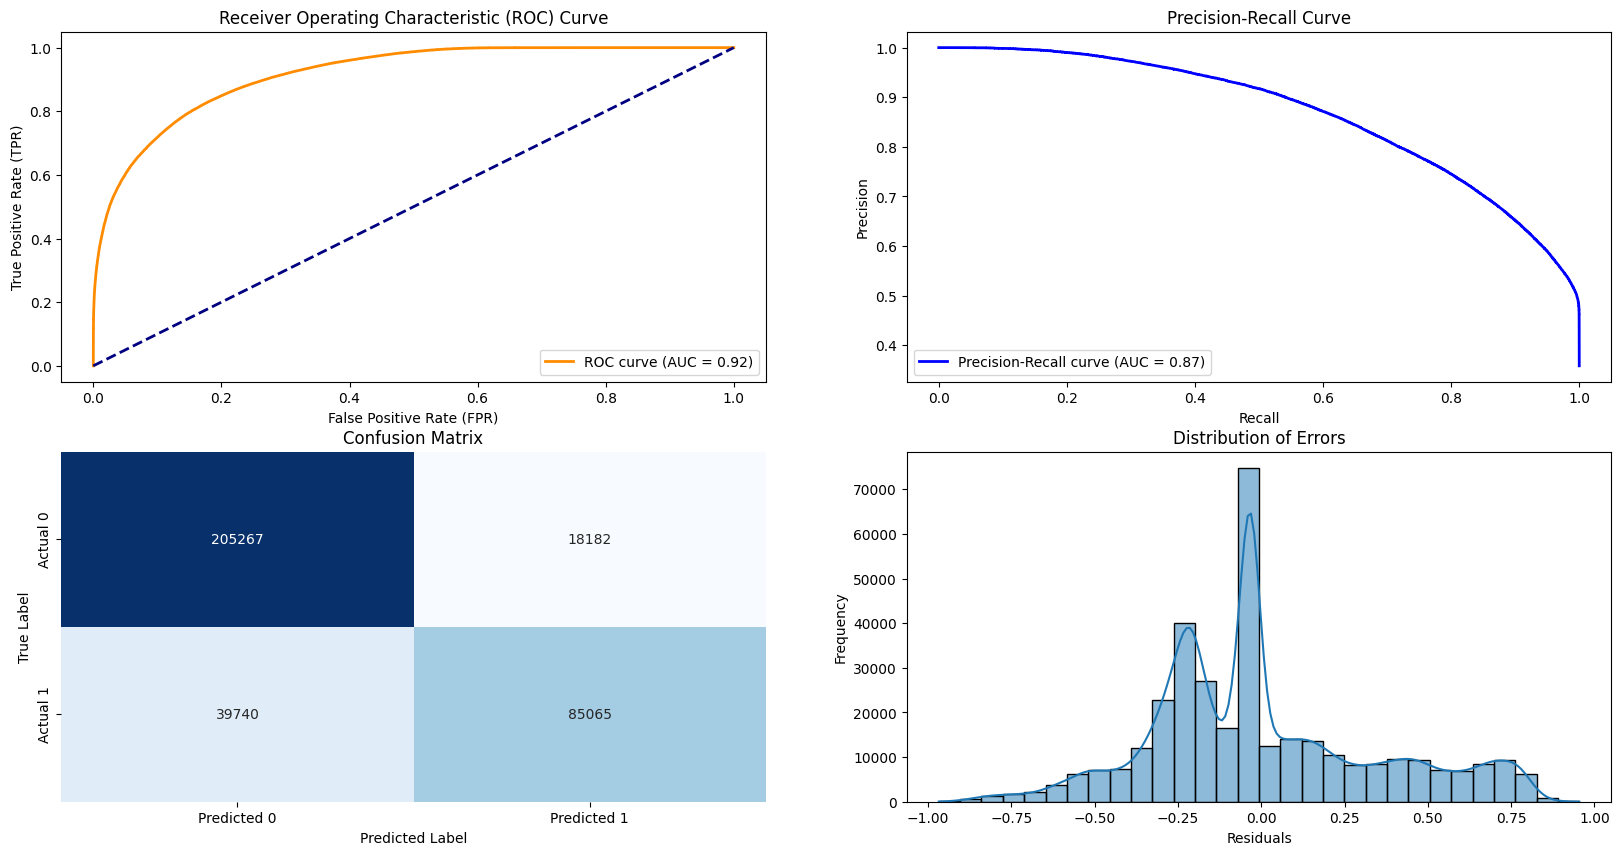

In [8]:
model = Model(GradientBoostingClassifier(n_estimators=50, learning_rate=0.2,max_depth=5,min_samples_leaf=50,
                                 min_samples_split=40,max_features='sqrt', random_state=42), name='Gradient Boosting Classifier')
model.fit()
model.visualize_metrics()

In [9]:
metrics_GBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC.to_frame().T])
print(metrics_GBC)

Accuracy                                     0.833679
Precision                                    0.823898
Recall                                       0.681583
F1-Score                                     0.746014
ROC AUC                                      0.915578
Confusion Matrix    [[205267, 18182], [39740, 85065]]
PR AUC                                       0.867363
Name                     Gradient Boosting Classifier
dtype: object


In [20]:
del model
del metrics_GBC

# Conclusion

In [ ]:
models_df

In [ ]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

In [ ]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

In [ ]:
for col in models_df.columns:
    if col != 'Confusion Matrix':
        print(models_df.sort_values(by=col, ascending=False)[col].head(1))